In [1]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from scipy.stats import randint as sp_randint

In [2]:
def norm_data(df):
    df = df.dropna()
    df=(df-df.min())/(df.max()-df.min())
    return df

def x_from_deg(deg, speed):
    return speed * np.cos(deg * np.pi/180)

def y_from_deg(deg, speed):
    return speed * np.sin(deg * np.pi/180) 

def calc_dir_change(a, b):
    diff = (a-b) % 360
    return np.minimum(diff, 360-diff)

def plot(df, x, y):
    d = df[df['erroneous']==0]
    plt.scatter(d[x], d[y], color='g', s=1)
    d = df[df['erroneous']==1]
    plt.scatter(d[x], d[y], color='r', s=1)
    plt.legend(['valid', 'erroneous'])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
def poly_logreg(degree, df, fields):
    poly = PolynomialFeatures(degree=degree)
    X = df[fields]
    X = poly.fit_transform(X)

    model = LogisticRegression(solver='lbfgs', max_iter=2000)
    y_pred = cross_val_predict(model,X, df['erroneous'], cv=3, n_jobs=-1)
    print(metrics.classification_report(df['erroneous'], y_pred))
    print(metrics.confusion_matrix(df['erroneous'], y_pred))
    ac = accuracy_score(df['erroneous'], y_pred)
    return ac

def pca_poly_logreg(df, degree, components):
    model = Pipeline([('pca', PCA(n_components=components)),
                     ('logreg', LogisticRegression(solver='lbfgs', max_iter=2000, class_weight='balanced'))])
    
    poly = PolynomialFeatures(degree=degree)
    X = df.loc[:, df.columns != 'erroneous']
    X = poly.fit_transform(X)
    
    y_pred = cross_val_predict(model,X, df['erroneous'], cv=3, n_jobs=-1)
    print(metrics.classification_report(df['erroneous'], y_pred))
    print(metrics.confusion_matrix(df['erroneous'], y_pred))
    ac = accuracy_score(df['erroneous'], y_pred)
    print(ac)
    return ac

def load_data_and_comparisons():
    csvs = ['001.csv', '002.csv', '003.csv', '004.csv', '005.csv', '006.csv', '007.csv', '008.csv']
    dfs = [pd.read_csv(os.path.join("labelled_all", c)) for c in csvs]

    for df in dfs:
        df['x'] = df.apply(lambda x: x_from_deg(x['dir'], x['speed']), axis=1)
        df['y'] = df.apply(lambda x: y_from_deg(x['dir'], x['speed']), axis=1)
    
    adf = pd.DataFrame(columns=('date', 'x_mean', 'y_mean', 'x_median', 'y_median'))
    
    df_combined = pd.concat(dfs)    
    df_combined = df_combined.groupby(df_combined.date)
    
    adf['x_mean'] = df_combined.mean()['x']
    adf['x_median'] = df_combined.median()['x']
    adf['y_mean'] = df_combined.mean()['y']
    adf['y_median'] = df_combined.median()['y']
    adf['date'] = df_combined['date']
    
    for i, df in enumerate(dfs):
        # for diff to other stations
        df['x_mean'] = adf['x_mean'].to_numpy()
        df['x_median'] = adf['x_median'].to_numpy()
        df['y_mean'] = adf['y_mean'].to_numpy()
        df['y_median'] = adf['y_median'].to_numpy()
        df['x_median_delta'] = (df['x'] - df['x_median']) ** 2
        df['y_median_delta'] = (df['y'] - df['y_median']) ** 2
        df['x_mean_delta'] = (df['x'] - df['x_mean']) ** 2
        df['y_mean_delta'] = (df['y'] - df['y_mean']) ** 2
        
        # prev readings
        # dir 
#         df['dir_i-1'] = df['dir'].shift(1)
#         df['dir_i-2'] = df['dir'].shift(2)
#         df['dir_i-3'] = df['dir'].shift(3)
        
        # diff from previous readings for dir
        dirs = df['dir'].shift(1).dropna()
        df["dir_prev_delta_1"] = calc_dir_change(df['dir'], dirs)
        dirs = df['dir'].shift(2).dropna()
        df["dir_prev_delta_2"] = calc_dir_change(df['dir'], dirs)
        dirs = df['dir'].shift(3).dropna()
        df["dir_prev_delta_3"] = calc_dir_change(df['dir'], dirs)

    
        df['dir_prev_mean_delta'] = df[['dir_prev_delta_1', 'dir_prev_delta_2', 'dir_prev_delta_3']].mean(axis=1)
        df['dir_prev_median_delta'] = df[['dir_prev_delta_1', 'dir_prev_delta_2', 'dir_prev_delta_3']].median(axis=1)
        
        df['x_prev_delta_1'] = df['x'].shift(1).dropna() - df['x']
        df['x_prev_delta_2'] = df['x'].shift(2).dropna() - df['x']
        df['x_prev_delta_3'] = df['x'].shift(3).dropna() - df['x']
        
        df['y_prev_delta_1'] = df['y'].shift(1).dropna() - df['y']
        df['y_prev_delta_2'] = df['y'].shift(2).dropna() - df['y']
        df['y_prev_delta_3'] = df['y'].shift(3).dropna() - df['y']
        
        df['x_prev_mean_delta'] = df[['x_prev_delta_1', 'x_prev_delta_2', 'x_prev_delta_3']].mean(axis=1)
        df['y_prev_mean_delta'] = df[['y_prev_delta_1', 'y_prev_delta_2', 'y_prev_delta_3']].mean(axis=1)
        df['x_prev_median_delta'] = df[['x_prev_delta_1', 'x_prev_delta_2', 'x_prev_delta_3']].median(axis=1)
        df['y_prev_median_delta'] = df[['y_prev_delta_1', 'y_prev_delta_2', 'y_prev_delta_3']].median(axis=1)
        
        # temp
        df['temp_prev_delta_1'] = df['temp'].shift(1).dropna() - df['temp']
        df['temp_prev_delta_2'] = df['temp'].shift(2).dropna() - df['temp']
        df['temp_prev_delta_3'] = df['temp'].shift(3).dropna() - df['temp']
        
        df['temp_prev_mean_delta'] = df[['temp_prev_delta_1', 'temp_prev_delta_2', 'temp_prev_delta_3']].mean(axis=1)
        df['temp_prev_mean_delta'] = df[['temp_prev_delta_1', 'temp_prev_delta_2', 'temp_prev_delta_3']].mean(axis=1)
        df['temp_prev_median_delta'] = df[['temp_prev_delta_1', 'temp_prev_delta_2', 'temp_prev_delta_3']].median(axis=1)
        df['temp_prev_median_delta'] = df[['temp_prev_delta_1', 'temp_prev_delta_2', 'temp_prev_delta_3']].median(axis=1)
        
#       # solar
        df['solar_prev_delta_1'] = df['solar'].shift(1).dropna() - df['solar']
        df['solar_prev_delta_2'] = df['solar'].shift(2).dropna() - df['solar']
        df['solar_prev_delta_3'] = df['solar'].shift(3).dropna() - df['solar']
        
        df['solar_prev_mean_delta'] = df[['solar_prev_delta_1', 'solar_prev_delta_2', 'solar_prev_delta_3']].mean(axis=1)
        df['solar_prev_mean_delta'] = df[['solar_prev_delta_1', 'solar_prev_delta_2', 'solar_prev_delta_3']].mean(axis=1)
        df['solar_prev_median_delta'] = df[['solar_prev_delta_1', 'solar_prev_delta_2', 'solar_prev_delta_3']].median(axis=1)
        df['solar_prev_median_delta'] = df[['solar_prev_delta_1', 'solar_prev_delta_2', 'solar_prev_delta_3']].median(axis=1)
    
        # speed
        df['speed_prev_delta_1'] = df['speed'].shift(1).dropna() - df['speed']
        df['speed_prev_delta_2'] = df['speed'].shift(2).dropna() - df['speed']
        df['speed_prev_delta_3'] = df['speed'].shift(3).dropna() - df['speed']
        
        df['speed_prev_mean_delta'] = df[['speed_prev_delta_1', 'speed_prev_delta_2', 'speed_prev_delta_3']].mean(axis=1)
        df['speed_prev_mean_delta'] = df[['speed_prev_delta_1', 'speed_prev_delta_2', 'speed_prev_delta_3']].mean(axis=1)
        df['speed_prev_median_delta'] = df[['speed_prev_delta_1', 'speed_prev_delta_2', 'speed_prev_delta_3']].median(axis=1)
        df['speed_prev_median_delta'] = df[['speed_prev_delta_1', 'speed_prev_delta_2', 'speed_prev_delta_3']].median(axis=1)

        
        
        del df['date']
#         df.loc[df.speed < 0.5, 'erroneous'] = 0

    return dfs

def optimize_pca_svm_hyperparams(df, kernel, iterations):
    model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel=kernel))])
    
    C_range = np.logspace(-2, 6, num=9)
    gamma_range = np.logspace(-2, 6, num=9)

    param_dist = {
        "svm__C": C_range,
        "svm__gamma": gamma_range
    }
    
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=iterations, cv=3, n_jobs=-1)

    random_search.fit(df.loc[:, df.columns != 'erroneous'], df['erroneous'])

    # summarize the results of the random search
    print(random_search.best_estimator_)
    print("best score", random_search.best_score_)
#     print("best C", random_search.best_estimator_.C)
#     if 'gamma' in param_dist:
#         print("best gamma", random_search.best_estimator_.gamma)
#     if 'degree' in param_dist:
#         print("best degree", random_search.best_estimator_.degree)
    print()

    
def plot_dec_boundry(model, df, fx, fy, scatter=True):   
    h = 0.1
    x_min, x_max = df[fx].min() - 2*h, df[fx].max() + 2*h
    y_min, y_max = df[fy].min() - 2*h, df[fy].max() + 2*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm.Paired)
    plt.axis('on')

    # Plot also the training points
#     colors = ['red' if y else 'blue' for y in df['erroneous']]
    if scatter:
        d = df[df['erroneous']==0]
        plt.scatter(d[fx], d[fy], color='b', s=1)
        d = df[df['erroneous']==1]
        plt.scatter(d[fx], d[fy], color='r', s=1)
#         plt.legend(['valid', 'erroneous'])
    plt.xlabel(fx)
    plt.ylabel(fy)

    plt.show()

In [3]:
df = norm_data(pd.concat(load_data_and_comparisons()))
df.to_csv("combined.csv")

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


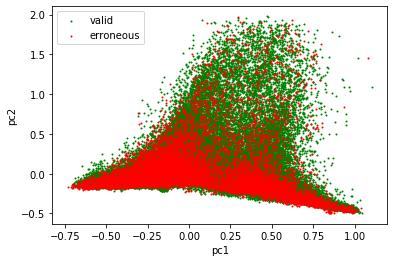

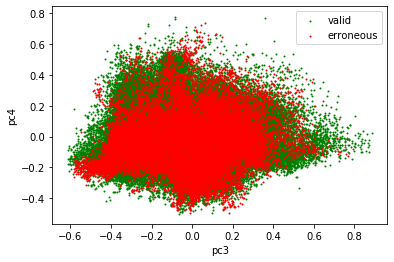

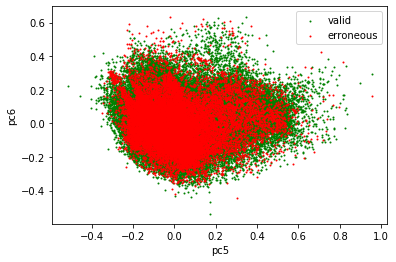

In [7]:
pca = PCA(n_components=44)
udf = df.loc[:, df.columns != 'erroneous']
pcs = pca.fit_transform(udf.values)

pdf = pd.DataFrame(data = pcs, columns = ['pc%s' % i for i in range(1, 44+1)])
pdf['erroneous'] = df[['erroneous']].values

plot(pdf, 'pc1', 'pc2')
plot(pdf, 'pc3', 'pc4')
plot(pdf, 'pc5', 'pc6')

[0.33390102 0.22199817 0.11659551 0.07267136 0.05914516 0.0360847
 0.02898814 0.02219649 0.02039026 0.01774871 0.01366354 0.01213505
 0.01078691 0.00783419 0.00534745 0.00352798 0.0025224  0.0021412
 0.00200261 0.001821  ]


Text(0, 0.5, 'Explained Variance Ratio')

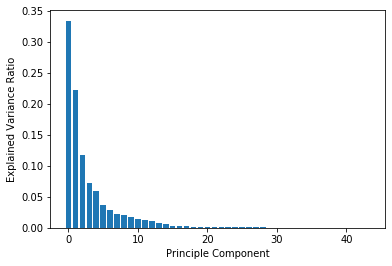

In [11]:
np.set_printoptions(threshold=sys.maxsize)
np.round(pca.components_, 2)
print(pca.explained_variance_ratio_[:20])
# print(pca.explained_variance_)

plt.bar([i for i in range(0, 44)], pca.explained_variance_ratio_)
plt.xlabel("Principle Component")
plt.ylabel("Explained Variance Ratio")

In [73]:
# pd.DataFrame(pcs, columns=['PC-1', 'PC-2'], index=df.columns)
i = np.identity(udf.shape[1])
coef = pca.transform(i)
pd.DataFrame(coef, columns=['pc%s' % i for i in range(1, udf.shape[1] + 1)], index=udf.columns)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44
temp,-0.227122,-0.065818,0.138271,-0.112301,0.642395,-0.392773,0.759533,-0.421860,1.437903,1.322723,...,0.009363,0.011578,-0.020880,0.001570,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
solar,-0.009666,0.002060,-0.110841,-0.666650,1.408535,0.564385,0.792621,-0.340191,1.256953,1.169054,...,0.010000,0.011672,-0.019685,0.001044,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
speed,-0.158609,-0.191555,-0.081873,-0.079006,0.387277,0.738726,1.301821,-0.704549,1.428038,0.899755,...,0.009236,0.014481,-0.020227,0.001938,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
dir,0.525928,-0.162827,0.146389,-0.929147,0.207073,0.346380,0.686470,-0.461897,1.397686,1.221149,...,0.009139,0.011430,-0.020414,0.001449,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
x,0.079034,-0.044973,-0.603728,-0.370743,0.552030,0.271531,0.708443,-0.364807,1.342714,1.155307,...,0.013044,0.003478,-0.020809,0.000824,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
y,-0.366208,0.026514,-0.330384,-0.591583,0.447494,0.442626,0.717886,-0.450126,1.379468,1.228713,...,0.010508,0.004172,-0.021389,-0.000384,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
x_mean,0.181780,-0.062482,-0.696902,-0.267371,0.540336,0.304153,0.654237,-0.427972,1.370313,1.228180,...,0.009983,0.013234,-0.020877,0.003247,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
x_median,0.182294,-0.062975,-0.686946,-0.267014,0.539341,0.298071,0.659457,-0.436178,1.372519,1.230685,...,0.007457,0.015705,-0.019253,-0.001347,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
y_mean,-0.479765,0.063661,-0.281769,-0.636642,0.367829,0.458214,0.508938,-0.351663,1.320493,1.205166,...,0.009984,0.018812,-0.017675,0.003188,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486
y_median,-0.460561,0.057532,-0.270223,-0.630875,0.369039,0.445380,0.525959,-0.358535,1.324838,1.203014,...,0.008750,0.009372,-0.021653,0.000683,0.049599,0.005485,0.008917,0.083819,-0.069967,-0.084486


# pca -> poly logistic regression

In [26]:
pca_poly_logreg(df, 2, 4)

              precision    recall  f1-score   support

         0.0       0.83      0.49      0.62    112804
         1.0       0.17      0.52      0.26     23116

    accuracy                           0.50    135920
   macro avg       0.50      0.51      0.44    135920
weighted avg       0.72      0.50      0.56    135920

[[55330 57474]
 [11045 12071]]
0.4958872866391995


0.4958872866391995

In [ ]:
pca_poly_logreg(df, 3, 4)

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
pca_poly_logreg(df, 4, 4)

# pca -> svm 

In [8]:
model = Pipeline([('pca', PCA(n_components=3)),
                 ('svm', SVC())])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91    112804
         1.0       0.00      0.00      0.00     23116

    accuracy                           0.83    135920
   macro avg       0.41      0.50      0.45    135920
weighted avg       0.69      0.83      0.75    135920

[[112804      0]
 [ 23116      0]]
0.8299293702177751


# # pca -> svm sigmoid

In [4]:
model = Pipeline([('pca', PCA(n_components=10)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    112804
         1.0       0.15      0.00      0.01     23116

    accuracy                           0.83    135920
   macro avg       0.49      0.50      0.46    135920
weighted avg       0.71      0.83      0.75    135920

[[112156    648]
 [ 23005    111]]
0.8259785167745732


In [5]:
model = Pipeline([('pca', PCA(n_components=7)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    112804
         1.0       0.13      0.01      0.01     23116

    accuracy                           0.82    135920
   macro avg       0.48      0.50      0.46    135920
weighted avg       0.71      0.82      0.75    135920

[[111694   1110]
 [ 22954    162]]
0.8229546792230724


In [6]:
model = Pipeline([('pca', PCA(n_components=6)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    112804
         1.0       0.11      0.01      0.01     23116

    accuracy                           0.82    135920
   macro avg       0.47      0.50      0.46    135920
weighted avg       0.71      0.82      0.75    135920

[[111396   1408]
 [ 22943    173]]
0.820843143025309


In [7]:
model = Pipeline([('pca', PCA(n_components=5)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90    112804
         1.0       0.22      0.04      0.07     23116

    accuracy                           0.81    135920
   macro avg       0.53      0.51      0.48    135920
weighted avg       0.73      0.81      0.75    135920

[[109657   3147]
 [ 22228    888]]
0.8133092995879929


In [8]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88    112804
         1.0       0.28      0.12      0.17     23116

    accuracy                           0.80    135920
   macro avg       0.56      0.53      0.53    135920
weighted avg       0.74      0.80      0.76    135920

[[105537   7267]
 [ 20270   2846]]
0.7974028840494408


In [9]:
model = Pipeline([('pca', PCA(n_components=3)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85    112804
         1.0       0.16      0.12      0.14     23116

    accuracy                           0.74    135920
   macro avg       0.49      0.49      0.49    135920
weighted avg       0.71      0.74      0.73    135920

[[97820 14984]
 [20341  2775]]
0.7401044732195409


In [10]:
model = Pipeline([('pca', PCA(n_components=2)),
                 ('svm', SVC(kernel='sigmoid'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85    112804
         1.0       0.17      0.13      0.15     23116

    accuracy                           0.74    135920
   macro avg       0.50      0.50      0.50    135920
weighted avg       0.72      0.74      0.73    135920

[[98154 14650]
 [20144  2972]]
0.7440111830488523


In [31]:
optimize_pca_svm_hyperparams(df, 'sigmoid', 30)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=4,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('svm',
                 SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.01,
                     kernel='sigmoid', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
best score 0.8411271336080047



In [11]:
model = Pipeline([('pca', PCA(n_components=2)),
                 ('svm', SVC(kernel='sigmoid', C=10000000, gamma=1))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84    112804
         1.0       0.18      0.18      0.18     23116

    accuracy                           0.73    135920
   macro avg       0.51      0.51      0.51    135920
weighted avg       0.72      0.73      0.72    135920

[[94704 18100]
 [19058  4058]]
0.7266185991759859


In [12]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=5000, gamma=0.01))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90    112804
         1.0       0.11      0.01      0.02     23116

    accuracy                           0.82    135920
   macro avg       0.47      0.50      0.46    135920
weighted avg       0.71      0.82      0.75    135920

[[111031   1773]
 [ 22903    213]]
0.818452030606239


In [13]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=10000, gamma=0.01))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89    112804
         1.0       0.25      0.07      0.11     23116

    accuracy                           0.81    135920
   macro avg       0.54      0.51      0.50    135920
weighted avg       0.73      0.81      0.76    135920

[[108175   4629]
 [ 21576   1540]]
0.8072027663331371


In [14]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=1000000, gamma=0.01))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85    112804
         1.0       0.28      0.28      0.28     23116

    accuracy                           0.75    135920
   macro avg       0.56      0.56      0.56    135920
weighted avg       0.75      0.75      0.75    135920

[[96218 16586]
 [16751  6365]]
0.7547307239552679


In [15]:
# best
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=1000000, gamma=0.1))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85    112804
         1.0       0.28      0.28      0.28     23116

    accuracy                           0.75    135920
   macro avg       0.56      0.56      0.56    135920
weighted avg       0.75      0.75      0.75    135920

[[96053 16751]
 [16748  6368]]
0.7535388463802236


In [16]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=10000000, gamma=1))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83    112804
         1.0       0.17      0.17      0.17     23116

    accuracy                           0.71    135920
   macro avg       0.50      0.50      0.50    135920
weighted avg       0.72      0.71      0.72    135920

[[92899 19905]
 [19079  4037]]
0.7131842260153031


In [17]:
model = Pipeline([('pca', PCA(n_components=2)),
                 ('svm', SVC(kernel='sigmoid', C=9000000, gamma=0.1))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83    112804
         1.0       0.16      0.16      0.16     23116

    accuracy                           0.71    135920
   macro avg       0.50      0.50      0.50    135920
weighted avg       0.72      0.71      0.71    135920

[[93272 19532]
 [19332  3784]]
0.7140670982931135


# # RBF

In [18]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='rbf'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91    112804
         1.0       0.00      0.00      0.00     23116

    accuracy                           0.83    135920
   macro avg       0.41      0.50      0.45    135920
weighted avg       0.69      0.83      0.75    135920

[[112804      0]
 [ 23116      0]]
0.8299293702177751


# # poly

In [19]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91    112804
         1.0       0.00      0.00      0.00     23116

    accuracy                           0.83    135920
   macro avg       0.41      0.50      0.45    135920
weighted avg       0.69      0.83      0.75    135920

[[112804      0]
 [ 23116      0]]
0.8299293702177751


 ## Weighted

In [17]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SGDClassifier())])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.64      0.72    112804
         1.0       0.18      0.38      0.24     23116

    accuracy                           0.60    135920
   macro avg       0.51      0.51      0.48    135920
weighted avg       0.72      0.60      0.64    135920

[[72219 40585]
 [14329  8787]]
0.5959829311359623


In [18]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SGDClassifier(class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.57      0.68    112804
         1.0       0.17      0.43      0.25     23116

    accuracy                           0.55    135920
   macro avg       0.50      0.50      0.46    135920
weighted avg       0.72      0.55      0.61    135920

[[64835 47969]
 [13087 10029]]
0.5507945850500294


In [75]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='rbf', class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77    112804
         1.0       0.19      0.34      0.25     23116

    accuracy                           0.65    135920
   macro avg       0.52      0.53      0.51    135920
weighted avg       0.73      0.65      0.68    135920

[[80650 32154]
 [15340  7776]]
0.6505738669805768


In [76]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.21      0.34    112804
         1.0       0.17      0.80      0.28     23116

    accuracy                           0.31    135920
   macro avg       0.50      0.51      0.31    135920
weighted avg       0.72      0.31      0.33    135920

[[24073 88731]
 [ 4700 18416]]
0.31260300176574457


In [77]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', C=1000 , class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.56      0.67    112804
         1.0       0.19      0.51      0.28     23116

    accuracy                           0.55    135920
   macro avg       0.52      0.53      0.48    135920
weighted avg       0.74      0.55      0.61    135920

[[62861 49943]
 [11286 11830]]
0.549521777516186


In [14]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', C=100 , class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.60      0.70    112804
         1.0       0.20      0.49      0.28     23116

    accuracy                           0.58    135920
   macro avg       0.52      0.54      0.49    135920
weighted avg       0.74      0.58      0.63    135920

[[67193 45611]
 [11899 11217]]
0.5768834608593291


In [15]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', C=10 , class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.60      0.70    112804
         1.0       0.19      0.47      0.27     23116

    accuracy                           0.58    135920
   macro avg       0.52      0.54      0.49    135920
weighted avg       0.74      0.58      0.63    135920

[[68063 44741]
 [12311 10805]]
0.5802530900529723


In [5]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', C=0.1 , class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.03      0.05    112804
         1.0       0.17      0.97      0.29     23116

    accuracy                           0.19    135920
   macro avg       0.50      0.50      0.17    135920
weighted avg       0.71      0.19      0.09    135920

[[  3140 109664]
 [   676  22440]]
0.18819894055326664


In [6]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='poly', C=10 , class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.60      0.70    112804
         1.0       0.19      0.47      0.27     23116

    accuracy                           0.58    135920
   macro avg       0.52      0.54      0.49    135920
weighted avg       0.74      0.58      0.63    135920

[[68072 44732]
 [12309 10807]]
0.5803340200117716


In [4]:
model = Pipeline([('pca', PCA(n_components=4)),
                 ('svm', SVC(kernel='sigmoid', C=1000000, gamma=0.1, class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.55      0.67    112804
         1.0       0.20      0.54      0.29     23116

    accuracy                           0.55    135920
   macro avg       0.53      0.54      0.48    135920
weighted avg       0.74      0.55      0.60    135920

[[62033 50771]
 [10653 12463]]
0.548087110064744


In [15]:
model = SVC(kernel='poly', class_weight='balanced')
# y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
# print(metrics.classification_report(df['erroneous'], y_pred))
# print(metrics.confusion_matrix(df['erroneous'], y_pred))
# print(accuracy_score(df['erroneous'], y_pred))

model.fit(pdf[['pc1', 'pc2']], df['erroneous'])

/Users/eben/Desktop/cs254/venv/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

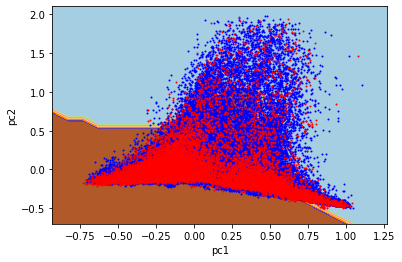

In [43]:
plot_dec_boundry(model, pdf, 'pc1', 'pc2')

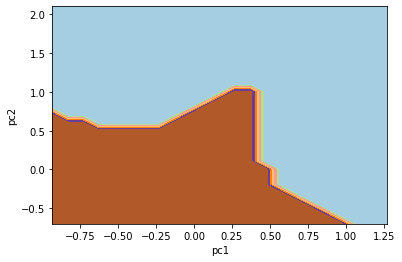

In [42]:
plot_dec_boundry(model, pdf, 'pc1', 'pc2', scatter=False)

In [48]:
model = SVC(kernel='sigmoid', C=1000000, gamma=0.1)
model.fit(pdf[['pc1', 'pc2']], df['erroneous'])

SVC(C=1000000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

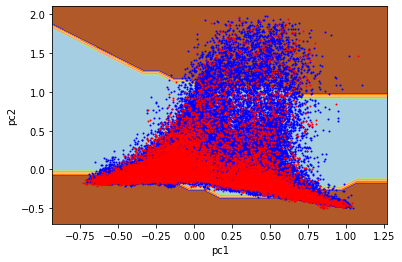

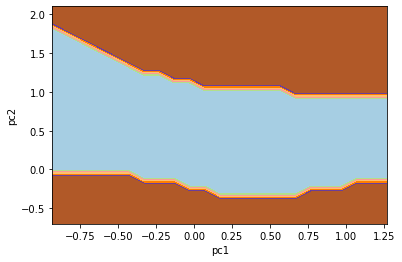

In [49]:
plot_dec_boundry(model, pdf, 'pc1', 'pc2')
plot_dec_boundry(model, pdf, 'pc1', 'pc2', scatter=False)

# samples_20k_30min.csv

In [3]:
df = pd.read_csv('samples_20k_30min.csv')
del df['time']
del df['time_min']
del df['Unnamed: 0']

df['erroneous'] = df['sum_all_labels'] > 0
df = df.drop(['label|speed:','label|temp:','label|solar:','label|dir:','label|u','label|v','sum_all_labels','sum_t1-n_labels'], axis=1)


le = preprocessing.LabelEncoder()
df['station'] = le.fit_transform(df['station'])

df = df.dropna()

df = norm_data(df)

In [4]:
df

,station,month,day,hour,minute,solar:|0,temp:|0,speed:|0,dir:|0,u|0,...,dir:|5,u|5,v|5,solar:|6,temp:|6,speed:|6,dir:|6,u|6,v|6,erroneous
0,0.166667,0.5,0.533333,0.652174,0.727273,0.137650,0.842425,0.273289,0.247911,0.999924,...,0.120891,0.843544,0.863287,0.150682,0.834058,0.184163,0.193872,0.968641,0.674286,0.0
1,1.000000,0.5,0.700000,0.434783,0.090909,0.414356,0.728370,0.065551,0.787744,0.012425,...,0.823955,0.049841,0.717616,0.230252,0.695904,0.036345,0.823955,0.049841,0.717616,0.0
2,0.500000,0.5,0.466667,0.521739,1.000000,0.787168,0.874397,0.378793,0.383287,0.837151,...,0.449582,0.659480,0.026116,0.798891,0.847886,0.239278,0.436212,0.698574,0.041123,0.0
3,0.166667,0.0,0.600000,0.695652,0.818182,0.134818,0.684979,0.172745,0.268524,0.996884,...,0.384401,0.834565,0.128428,0.089771,0.670552,0.177954,0.394986,0.809204,0.107072,0.0
4,0.500000,0.5,0.066667,0.000000,0.909091,0.001412,0.559376,0.496965,0.329248,0.940652,...,0.318663,0.955342,0.293448,0.000874,0.543790,0.513134,0.317549,0.956773,0.296632,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.833333,0.5,0.233333,0.260870,0.272727,0.000000,0.646157,0.041537,0.222284,0.992098,...,0.361003,0.885257,0.181288,0.000000,0.631371,0.012800,0.364903,0.877355,0.171970,1.0
19996,0.666667,0.0,0.533333,0.217391,0.454545,0.000000,0.203249,0.168734,0.308635,0.967413,...,0.327577,0.943102,0.268352,0.000000,0.246608,0.211290,0.328134,0.942290,0.266807,1.0
19997,0.833333,0.0,0.700000,0.739130,0.909091,0.000000,0.673561,0.291128,0.305850,0.970440,...,0.318106,0.956060,0.295038,0.016033,0.679771,0.206419,0.311421,0.964243,0.314316,1.0
19998,0.666667,0.5,0.300000,0.130435,0.363636,0.000000,0.758058,0.026337,0.944847,0.322447,...,0.133705,0.871572,0.834565,0.000000,0.778875,0.000000,0.166017,0.931257,0.753017,0.0


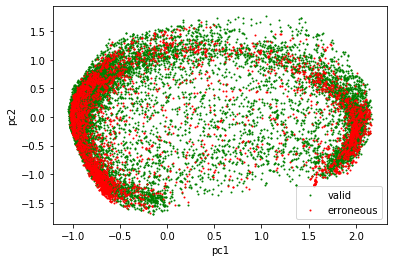

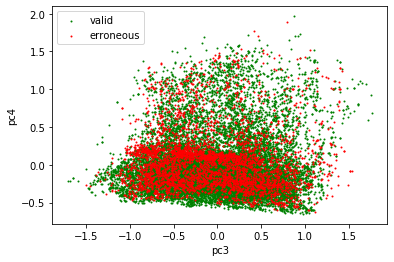

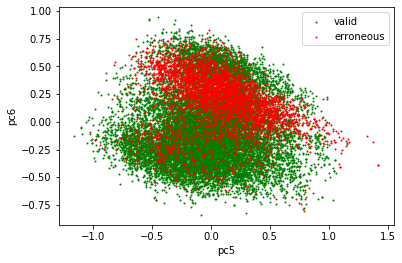

In [11]:
pca = PCA(n_components=df.shape[1] - 1)
udf = df.loc[:, df.columns != 'erroneous']
pcs = pca.fit_transform(udf.values)

pdf = pd.DataFrame(data = pcs, columns = ['pc%s' % i for i in range(1, df.shape[1])])
pdf['erroneous'] = df[['erroneous']].values

plot(pdf, 'pc1', 'pc2')
plot(pdf, 'pc3', 'pc4')
plot(pdf, 'pc5', 'pc6')

[0.43008557 0.15500527 0.09237921 0.05119283 0.03968416 0.034279
 0.03232668 0.0288633  0.0263404  0.01996849 0.01872243 0.01344599
 0.01102186 0.00724452 0.00571515 0.00391349 0.00351333 0.00347854
 0.00284694 0.00247296]


Text(0, 0.5, 'Explained Variance Ratio')

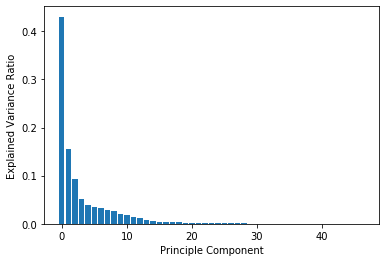

In [12]:
np.set_printoptions(threshold=sys.maxsize)
np.round(pca.components_, 2)
print(pca.explained_variance_ratio_[:20])
# print(pca.explained_variance_)

plt.bar([i for i in range(0, df.shape[1] - 1)], pca.explained_variance_ratio_)
plt.xlabel("Principle Component")
plt.ylabel("Explained Variance Ratio")

In [9]:
model = Pipeline([('pca', PCA(n_components=10)),
                 ('svm', SVC(class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.66      0.77     15812
         1.0       0.40      0.85      0.54      4188

    accuracy                           0.70     20000
   macro avg       0.67      0.75      0.66     20000
weighted avg       0.83      0.70      0.72     20000

[[10369  5443]
 [  623  3565]]
0.6967


In [8]:
model = Pipeline([('pca', PCA(n_components=15)),
                 ('svm', SVC(class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.66      0.78     15812
         1.0       0.40      0.85      0.54      4188

    accuracy                           0.70     20000
   macro avg       0.67      0.75      0.66     20000
weighted avg       0.83      0.70      0.73     20000

[[10501  5311]
 [  646  3542]]
0.70215


In [5]:
model = Pipeline([('pca', PCA(n_components=10)),
                 ('svm', SGDClassifier(class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78     15812
         1.0       0.39      0.81      0.53      4188

    accuracy                           0.70     20000
   macro avg       0.66      0.74      0.65     20000
weighted avg       0.82      0.70      0.73     20000

[[10606  5206]
 [  808  3380]]
0.6993


In [5]:
model = Pipeline([('pca', PCA(n_components=8)),
                 ('svm', SVC(kernel='poly', class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82     15812
         1.0       0.42      0.66      0.51      4188

    accuracy                           0.74     20000
   macro avg       0.66      0.71      0.67     20000
weighted avg       0.80      0.74      0.76     20000

[[12004  3808]
 [ 1415  2773]]
0.73885


In [15]:
model = Pipeline([('pca', PCA(n_components=20)),
                 ('svm', SVC(kernel='sigmoid', class_weight='balanced', C=.1))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.61      0.74     15812
         1.0       0.37      0.86      0.51      4188

    accuracy                           0.66     20000
   macro avg       0.65      0.73      0.63     20000
weighted avg       0.82      0.66      0.69     20000

[[9606 6206]
 [ 605 3583]]
0.65945


In [17]:
model = Pipeline([('pca', PCA(n_components=20)),
                 ('svm', SVC(kernel='rbf', class_weight='balanced'))])
y_pred = cross_val_predict(model, df.loc[:, df.columns != 'erroneous'], df['erroneous'], cv=3, n_jobs=-1)
print(metrics.classification_report(df['erroneous'], y_pred))
print(metrics.confusion_matrix(df['erroneous'], y_pred))
print(accuracy_score(df['erroneous'], y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.66      0.78     15812
         1.0       0.40      0.84      0.54      4188

    accuracy                           0.70     20000
   macro avg       0.67      0.75      0.66     20000
weighted avg       0.83      0.70      0.73     20000

[[10480  5332]
 [  685  3503]]
0.69915
